In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *


In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
human_mouse_sect_cons = '../fig5/human_mouse_sect_cons.tsv'


ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
min_perc = 80

## Human

In [4]:
min_samples = 10

In [5]:
ca = cerberus.read(cerberus_h5)

In [6]:
# limit to protein coding
g_df, _, _ = get_gtf_info(ver=ver, how='gene', add_stable_gid=True)
g_df = g_df[['gid_stable', 'biotype_category']]
g_df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
pc_gids = g_df.loc[g_df.biotype_category=='protein_coding'].gid.tolist()
print(len(ca.triplets.index))
ca.triplets = ca.triplets.loc[ca.triplets.gid.isin(pc_gids)]
print(len(ca.triplets.index))

1567754
1278516


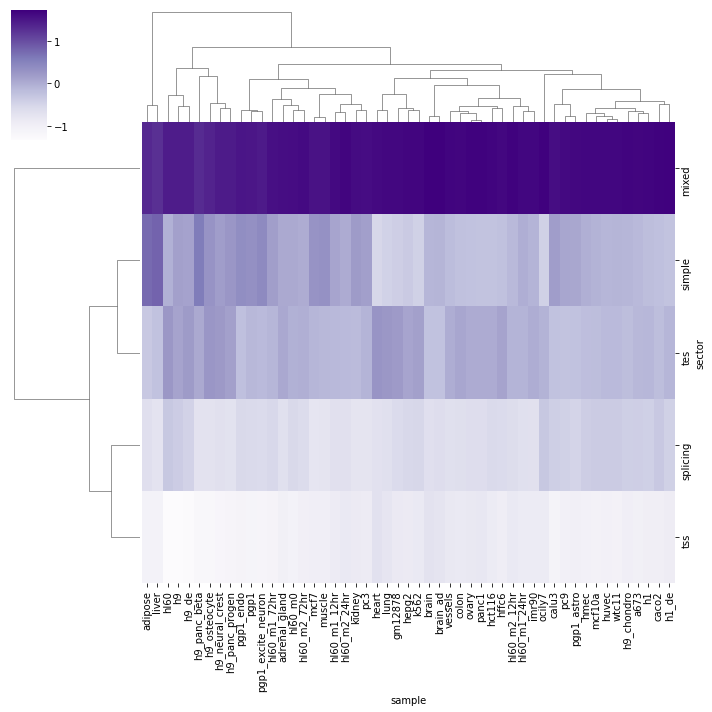

In [7]:
# heatmap of n genes in each sector across samples
df = ca.triplets.copy(deep=True)
df = df.loc[df.source=='sample_det']
df = df[['sample', 'sector', 'gid']].groupby(['sample', 'sector']).nunique().reset_index().rename({'gid':'n_genes'}, axis=1)
df = df.pivot(columns='sample', index='sector', values='n_genes')
df.head()
sns.clustermap(df, cmap='Purples', xticklabels=True, z_score=1)

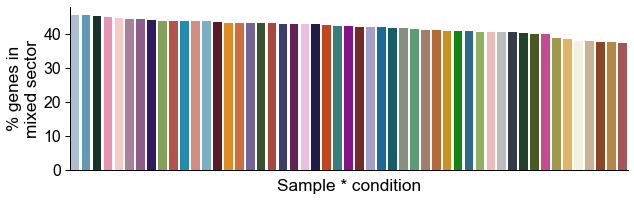

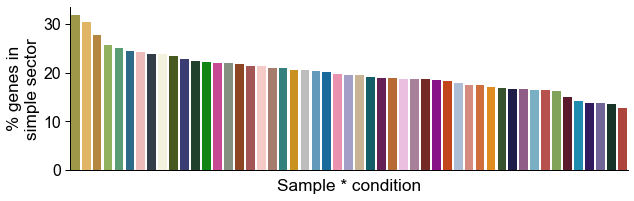

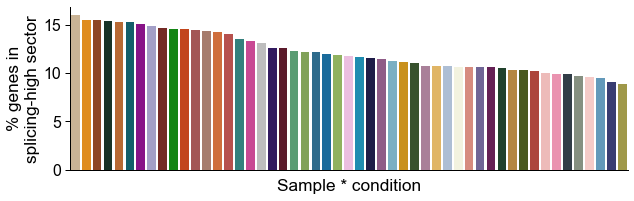

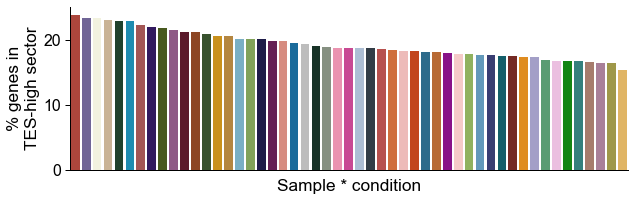

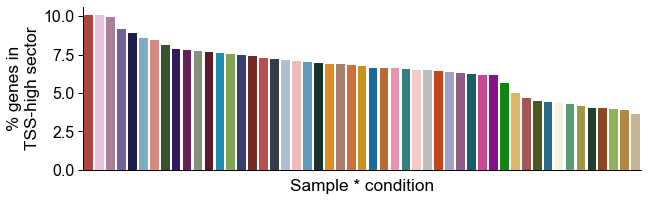

In [8]:
# ranked bar plot of % genes in each sector by sample
df = ca.triplets.copy(deep=True)
df = df.loc[df.source=='sample_det']
df = df[['sample', 'sector', 'gid']].groupby(['sample', 'sector']).nunique().reset_index().rename({'gid':'n_genes'}, axis=1)
temp = df[['sample', 'n_genes']].groupby('sample').sum().reset_index().rename({'n_genes':'n_tot_genes'}, axis=1)
df = df.merge(temp, how='left', on='sample')
df['perc'] = (df['n_genes']/df['n_tot_genes'])*100

meta_df = pd.read_csv(lib_meta, sep='\t')
meta_df = meta_df[['sample', 'sample_display', 'sample_color_hex_code']].drop_duplicates()
c_dict = dict([(s, c) for s,c in zip(meta_df.sample_display.tolist(),
                                     meta_df.sample_color_hex_code.tolist())])
df = df.merge(meta_df, how='left', on='sample')
for s in df.sector.unique().tolist():
    
    sns.set_context('paper', font_scale=1.8)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    plt.figure(figsize=(10,3))
    
    temp = df.loc[df.sector==s]
    temp = temp.sort_values(by='perc', ascending=False)
    ax = sns.barplot(temp, y='perc', x='sample_display', palette=c_dict)
    if s in ['tss', 'tes']:
        s_label = s.upper()
    else:
        s_label = s
    if s in ['tss', 'tes', 'splicing']:
        s_label+='-high'
    ylabel = f'% genes in\n{s_label} sector'
    xlabel = 'Sample * condition'
    ax.set(ylabel=ylabel, xlabel=xlabel)
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    fname = f'figures/{s}_perc_genes_per_sect_sample.pdf'
    plt.savefig
    plt.show()
    

,sample,sector,n_genes,n_tot_genes,perc,sample_display,sample_color_hex_code
0,a673,mixed,4838,11359,42.591777,A673,#de3700
1,a673,simple,2067,11359,18.197024,A673,#de3700
2,a673,splicing,1649,11359,14.517123,A673,#de3700
3,a673,tes,2074,11359,18.258650,A673,#de3700
4,a673,tss,731,11359,6.435426,A673,#de3700


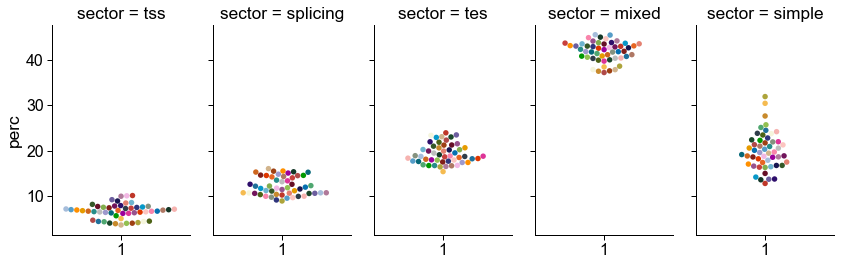

In [9]:
# catplot
df = ca.triplets.copy(deep=True)
df = df.loc[df.source=='sample_det']
df = df[['sample', 'sector', 'gid']].groupby(['sample', 'sector']).nunique().reset_index().rename({'gid':'n_genes'}, axis=1)
temp = df[['sample', 'n_genes']].groupby('sample').sum().reset_index().rename({'n_genes':'n_tot_genes'}, axis=1)
df = df.merge(temp, how='left', on='sample')
df['perc'] = (df['n_genes']/df['n_tot_genes'])*100
c_dict, order = get_biosample_colors()
c_dict_2, order_2 = get_sector_colors()
g = sns.catplot(data=df, x=1, y='perc', kind='swarm',
            height=4, aspect=.6, hue='sample', s=30,
            col_order=order_2,
            palette=c_dict, col='sector', legend=False)
meta_df = pd.read_csv(lib_meta, sep='\t')
meta_df = meta_df[['sample', 'sample_display', 'sample_color_hex_code']].drop_duplicates()
df = df.merge(meta_df, how='left', on='sample')
df.to_csv('sample_sector_perc_genes_for_sam.tsv', sep='\t', index=False)
df.head()


## Mode comparisons

In [10]:
# limit to sample_det
df = ca.triplets.copy(deep=True)

df = ca.triplets.copy(deep=True)

# remove genes that are simply globally
gids = df.loc[(df.source=='obs_det')&(df.sector=='simple'), 'gid'].tolist()
print(len(df.index))
df = df.loc[~df.gid.isin(gids)]
print(len(df.index))
            

df = df.loc[df.source=='sample_det']

# for each gene, compute the mode sector
temp = df[['gid', 'sector']].groupby('gid').agg(lambda x: st.mode(x)[0]).reset_index().rename({'sector':'mode_sector'}, axis=1)
df = df.merge(temp, how='left', on='gid')

# which samples have the same sector as mode?
df['same_as_mode'] = df.sector==df.mode_sector
df.head()

# what % of samples / gene have the same sector?
temp = df[['gid', 'same_as_mode', 'mode_sector', 'sample']].groupby(['gid', 'same_as_mode', 'mode_sector']).count().reset_index().rename({'sample':'n_samples'}, axis=1)
temp2 = df[['gid', 'sample']].groupby('gid').count().reset_index().rename({'sample':'n_tot_samples'}, axis=1)
temp = temp.merge(temp2, how='left', on='gid')

# remove things that are only expressed in a few samples
temp = temp.loc[temp.n_tot_samples >= min_samples]
temp['perc'] = (temp.n_samples/temp.n_tot_samples)*100

# # remove things that are all simple
# temp = temp.loc[temp.mode_sector != 'simple']

# now get the 2nd mode
temp2 = df.loc[df.same_as_mode==False]
temp2 = temp2[['gid', 'sector']].groupby('gid').agg(lambda x: st.mode(x)[0]).reset_index().rename({'sector':'mode_sector_2'}, axis=1)
temp = temp.merge(temp2, 
                  on='gid',
                  how='left')

# add biotype info
g_df, _, _ = get_gtf_info(ver=ver, how='gene', add_stable_gid=True)
temp = temp.merge(g_df[['gid_stable',
                      'gname',
                      'biotype_category']].rename({'gid_stable':'gid'}, axis=1),
                      how='left', on='gid')

1278516
1237209


In [11]:
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category
0,ENSG00000000003,False,tes,4,42,9.523810,mixed,TSPAN6,protein_coding
1,ENSG00000000003,True,tes,38,42,90.476190,mixed,TSPAN6,protein_coding
2,ENSG00000000419,False,mixed,24,51,47.058824,splicing,DPM1,protein_coding
3,ENSG00000000419,True,mixed,27,51,52.941176,splicing,DPM1,protein_coding
4,ENSG00000000457,False,mixed,27,49,55.102041,simple,SCYL3,protein_coding


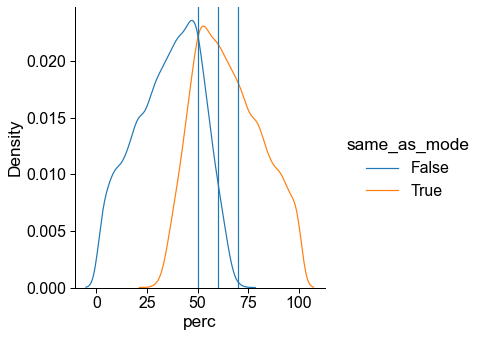

In [12]:
ax = sns.displot(temp, 
                 x='perc',
                 hue='same_as_mode',
                 common_norm=False,
                 kind='kde')
plt.axvline(x=50)
plt.axvline(x=60)
plt.axvline(x=70)

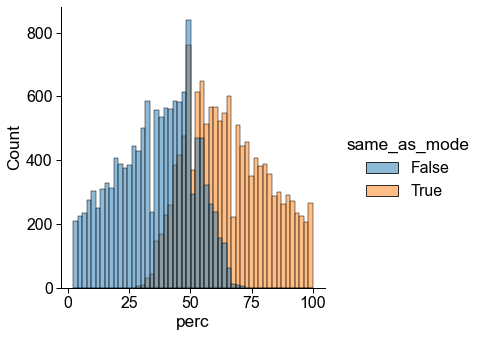

In [13]:
ax = sns.displot(temp, 
                 x='perc',
                 hue='same_as_mode')

In [14]:
temp2

,gid,mode_sector_2
0,ENSG00000000003,mixed
1,ENSG00000000419,splicing
2,ENSG00000000457,simple
3,ENSG00000000460,simple
4,ENSG00000000938,simple
...,...,...
14856,ENSG00000285133,tes
14857,ENSG00000285437,mixed
14858,ENSG00000285625,mixed
14859,ENSG00000285816,tes


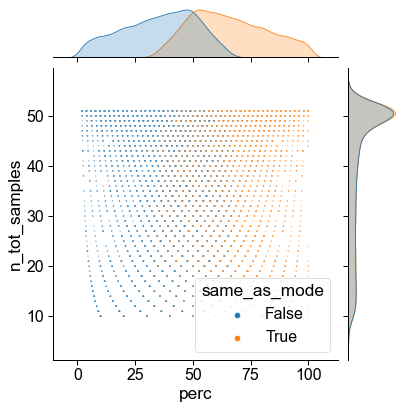

In [15]:
ax = sns.jointplot(temp,
                   x='perc',
                   y='n_tot_samples',
                   hue='same_as_mode',
                   joint_kws={'s':2,
                              'alpha':0.5})

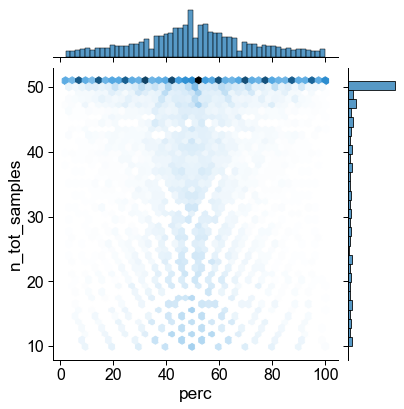

In [16]:
temp2 = temp.loc[temp.same_as_mode==True] 
ax = sns.jointplot(temp,
                   x='perc',
                   y='n_tot_samples',
                   kind='hex')

In [17]:
df.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,mode_sector,same_as_mode
0,sample_det,ENSG00000000003,1.0,4.0,3.0,9.0,1.200000,0.161290,0.645161,0.193548,tes,TSPAN6,hffc6,47.245121,tes,True
1,sample_det,ENSG00000000419,2.0,2.0,8.0,9.0,4.000000,0.250000,0.250000,0.500000,mixed,DPM1,hffc6,84.884636,mixed,True
2,sample_det,ENSG00000000457,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,SCYL3,hffc6,4.080011,mixed,False
3,sample_det,ENSG00000000460,1.0,2.0,2.0,2.0,1.333333,0.230769,0.461538,0.307692,mixed,C1orf112,hffc6,6.976301,mixed,True
4,sample_det,ENSG00000000971,1.0,5.0,5.0,5.0,1.666667,0.130435,0.652174,0.217391,tes,CFH,hffc6,20.044918,mixed,False


In [18]:
# look at max. number of isoforms
temp2 = df[['gid', 'n_iso']].groupby('gid').max().rename({'n_iso':'max_n_iso'}, axis=1).reset_index()
temp = temp.merge(temp2, 
                  how='left',
                  on='gid')
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso
0,ENSG00000000003,False,tes,4,42,9.523810,mixed,TSPAN6,protein_coding,19.0
1,ENSG00000000003,True,tes,38,42,90.476190,mixed,TSPAN6,protein_coding,19.0
2,ENSG00000000419,False,mixed,24,51,47.058824,splicing,DPM1,protein_coding,10.0
3,ENSG00000000419,True,mixed,27,51,52.941176,splicing,DPM1,protein_coding,10.0
4,ENSG00000000457,False,mixed,27,49,55.102041,simple,SCYL3,protein_coding,5.0


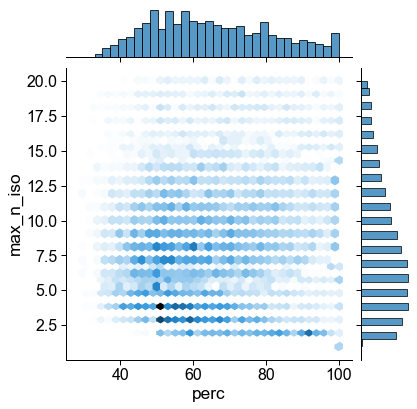

In [19]:
temp2 = temp.loc[temp.same_as_mode==True] 
temp2 = temp2.loc[temp2.max_n_iso<=20]
ax = sns.jointplot(temp2,
                   x='perc',
                   y='max_n_iso',
                   kind='hex')

In [20]:
temp.loc[temp.max_n_iso == 1]

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso
2529,ENSG00000080573,True,simple,10,10,100.0,NaN,COL5A3,protein_coding,1.0
5008,ENSG00000104953,True,simple,11,11,100.0,NaN,TLE6,protein_coding,1.0
7185,ENSG00000115020,True,simple,10,10,100.0,NaN,PIKFYVE,protein_coding,1.0
8250,ENSG00000120051,True,simple,16,16,100.0,NaN,CFAP58,protein_coding,1.0
9354,ENSG00000125965,True,simple,17,17,100.0,NaN,GDF5,protein_coding,1.0
10655,ENSG00000132510,True,simple,10,10,100.0,NaN,KDM6B,protein_coding,1.0
12953,ENSG00000141086,True,simple,11,11,100.0,NaN,CTRL,protein_coding,1.0
13525,ENSG00000143630,True,simple,16,16,100.0,NaN,HCN3,protein_coding,1.0
17976,ENSG00000165029,True,simple,12,12,100.0,NaN,ABCA1,protein_coding,1.0
18028,ENSG00000165197,True,simple,13,13,100.0,NaN,VEGFD,protein_coding,1.0


## What sectors are the most sample-conserved vs. least?

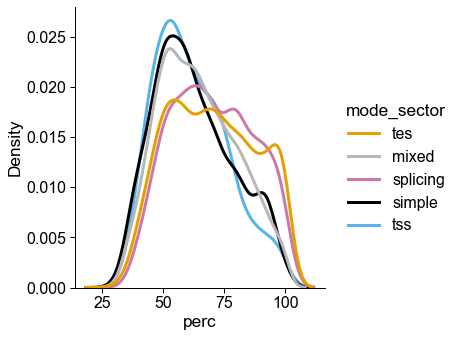

In [21]:
temp2 = temp.loc[temp.same_as_mode == True]
c_dict, order = get_sector_colors()
ax = sns.displot(temp2, 
                 x='perc',
                 hue='mode_sector',
                 palette=c_dict,
                 kind='kde',
                 linewidth=3,
                 common_norm=False)

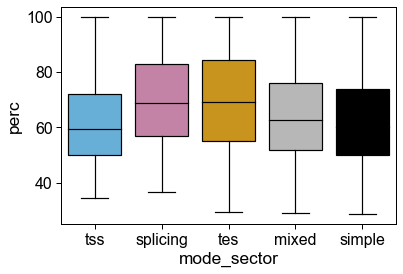

In [22]:
temp.head()
temp2 = temp.loc[temp.same_as_mode == True]
c_dict, order = get_sector_colors(cats=temp2.mode_sector.unique().tolist())
ax = sns.boxplot(temp2, 
                 y='perc',
                 x='mode_sector',
                order=order,
                palette=c_dict)

In [69]:
temp2

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso,n_tot_genes
42,ENSG00000002587,False,tss,15,27,55.555556,mixed,HS3ST1,protein_coding,8.0,13723
43,ENSG00000002587,True,tss,12,27,44.444444,mixed,HS3ST1,protein_coding,8.0,13723
59,ENSG00000003249,False,tss,13,42,30.952381,mixed,DBNDD1,protein_coding,7.0,13723
60,ENSG00000003249,True,tss,29,42,69.047619,mixed,DBNDD1,protein_coding,7.0,13723
185,ENSG00000005844,False,tss,9,17,52.941176,mixed,ITGAL,protein_coding,7.0,13723
...,...,...,...,...,...,...,...,...,...,...,...
27133,ENSG00000281991,True,tss,19,39,48.717949,simple,TMEM265,protein_coding,6.0,13723
27140,ENSG00000283189,False,tss,11,24,45.833333,simple,ENSG00000283189,protein_coding,4.0,13723
27141,ENSG00000283189,True,tss,13,24,54.166667,simple,ENSG00000283189,protein_coding,4.0,13723
27168,ENSG00000285043,False,tss,14,51,27.450980,mixed,ENSG00000285043,protein_coding,9.0,13723


tes vs. mixed stat: 10111197.0, pval: 2.1807454706695787e-44
tes vs. splicing stat: 1680801.5, pval: 0.6370105438646558
tes vs. simple stat: 3938950.0, pval: 6.4678331802939815e-49
tes vs. tss stat: 1325536.5, pval: 1.3266907696985545e-31
mixed vs. splicing stat: 3404460.5, pval: 1.9355702356788072e-32
mixed vs. simple stat: 8535090.0, pval: 9.416272805803015e-06
mixed vs. tss stat: 2881950.0, pval: 1.630368205245059e-05
splicing vs. simple stat: 2021715.5, pval: 7.317556165838836e-40
splicing vs. tss stat: 681947.0, pval: 9.052291428849927e-31
simple vs. splicing stat: 1184192.5, pval: 7.317556165838836e-40
simple vs. tss stat: 1011743.5, pval: 0.23109683291657812
tss vs. splicing stat: 368377.0, pval: 9.052291428849927e-31
tss vs. simple stat: 956409.5, pval: 0.23109683291657812

Med. % samples same as tes mode: 69.23076923076923
Med. % samples same as mixed mode: 62.745098039215684
Med. % samples same as splicing mode: 68.81944444444444
Med. % samples same as simple mode: 60.0
Med. 

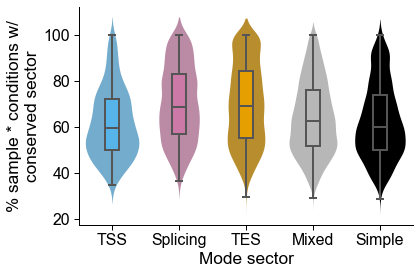

In [23]:
temp.head()
temp2 = temp.loc[temp.same_as_mode == True]
c_dict, order = get_sector_colors(cats=temp2.mode_sector.unique().tolist())
sns.set_context('paper', font_scale=1.8)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(6,4))
shade_dict, _ = get_shade_colors('#000000', ['dummy', False, True])
linecolor = shade_dict[False]
# ax = sns.boxplot(temp2, 
#                  y='perc',
#                  x='mode_sector',
#                 order=order,
#                 palette=c_dict,
#                 saturation=1,
#                 linewidth=2)

ax = sns.violinplot(temp2, y='perc',
                    x='mode_sector',
                    order=order,
                    palette=c_dict,
                    saturation=0.6,
                    inner=None, linewidth=0)

ax = sns.boxplot(temp2, y='perc',
                 x='mode_sector',
                 order=order,
                 palette=c_dict,
                 saturation=1,
                 width=0.2,
                 linewidth=2,
                 boxprops={'zorder': 2}, ax=ax)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
xlabel = 'Mode sector'
ylabel = '% sample * conditions w/\nconserved sector'
xticklabels = [s.get_text().upper() if s.get_text() in ['tss', 'tes'] else s.get_text().capitalize() for s in ax.get_xticklabels()]
_ = ax.set(ylabel=ylabel, xlabel=xlabel, xticklabels=xticklabels)

box_patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax.artists
    box_patches = ax.artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):

    # Set the linecolor on the patch to the facecolor, and set the facecolor to None
    patch.set_edgecolor(linecolor)

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(linecolor)
        line.set_mfc(linecolor)  # facecolor of fliers
        line.set_mec(linecolor)  # edgecolor of fliers

# stats test
pvals = {}
for i in temp2.mode_sector.unique():
    for j in temp2.mode_sector.unique():
        if i==j: continue
        
        key = tuple(set([i,j]))
        if key in pvals.keys(): continue
        x = temp2.loc[temp2.mode_sector==i, 'perc'].dropna().tolist()
        y = temp2.loc[temp2.mode_sector==j, 'perc'].dropna().tolist()
        stat, pval = st.mannwhitneyu(x,y)
        pvals[key] = pval
        print(f'{i} vs. {j} stat: {stat}, pval: {pval}')
    
print()
for i in temp2.mode_sector.unique():
    print(f"Med. % samples same as {i} mode: {temp2.loc[temp2.mode_sector==i, 'perc'].median()}")
    
fname = 'figures/human_sample_sector_conservation_violin.pdf'
plt.savefig(fname, dpi=500)

In [70]:
temp2

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso,n_tot_genes
42,ENSG00000002587,False,tss,15,27,55.555556,mixed,HS3ST1,protein_coding,8.0,13723
43,ENSG00000002587,True,tss,12,27,44.444444,mixed,HS3ST1,protein_coding,8.0,13723
59,ENSG00000003249,False,tss,13,42,30.952381,mixed,DBNDD1,protein_coding,7.0,13723
60,ENSG00000003249,True,tss,29,42,69.047619,mixed,DBNDD1,protein_coding,7.0,13723
185,ENSG00000005844,False,tss,9,17,52.941176,mixed,ITGAL,protein_coding,7.0,13723
...,...,...,...,...,...,...,...,...,...,...,...
27133,ENSG00000281991,True,tss,19,39,48.717949,simple,TMEM265,protein_coding,6.0,13723
27140,ENSG00000283189,False,tss,11,24,45.833333,simple,ENSG00000283189,protein_coding,4.0,13723
27141,ENSG00000283189,True,tss,13,24,54.166667,simple,ENSG00000283189,protein_coding,4.0,13723
27168,ENSG00000285043,False,tss,14,51,27.450980,mixed,ENSG00000285043,protein_coding,9.0,13723


## What % of these genes have "conserved" behavior across samples?

In [24]:
n = len(temp.gid.unique().tolist())
n_num = len(temp.loc[(temp.same_as_mode==True)&(temp.perc>=min_perc)].index)
print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) genes have >={min_perc}% of expressed samples in the same sector as the mode')

22.48% (3085/13723) genes have >=80% of expressed samples in the same sector as the mode


## What % of these genes have "conserved" behavior across samples; by mode sector

In [55]:
temp['n_tot_genes'] = len(temp.gid.unique().tolist())
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso,n_tot_genes
0,ENSG00000000003,False,tes,4,42,9.523810,mixed,TSPAN6,protein_coding,19.0,13723
1,ENSG00000000003,True,tes,38,42,90.476190,mixed,TSPAN6,protein_coding,19.0,13723
2,ENSG00000000419,False,mixed,24,51,47.058824,splicing,DPM1,protein_coding,10.0,13723
3,ENSG00000000419,True,mixed,27,51,52.941176,splicing,DPM1,protein_coding,10.0,13723
4,ENSG00000000457,False,mixed,27,49,55.102041,simple,SCYL3,protein_coding,5.0,13723


32.77% (850/2594) genes have >=80% of expressed samples in the same tes sector as the mode
19.37% (1272/6567) genes have >=80% of expressed samples in the same mixed sector as the mode
32.26% (422/1308) genes have >=80% of expressed samples in the same splicing sector as the mode
17.99% (441/2451) genes have >=80% of expressed samples in the same simple sector as the mode
12.45% (100/803) genes have >=80% of expressed samples in the same tss sector as the mode


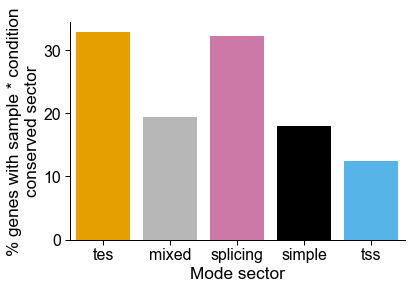

In [56]:
temp12 = pd.DataFrame()
mode_sects = []
percs = []
perc_2 = []
ns = []
n_nums = []
for s in temp.mode_sector.unique().tolist():
    temp2 = temp.loc[temp.mode_sector==s]
    n = len(temp2.gid.unique().tolist())
    n_num = len(temp2.loc[(temp2.same_as_mode==True)&(temp2.perc>=min_perc)].index)
    print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) genes have >={min_perc}% of expressed samples in the same {s} sector as the mode')
    mode_sects.append(s)
    percs.append((n_num/n)*100)
    n_tot = temp.n_tot_genes.values[0]
    perc_2.append((n/n_tot)*100)
    ns.append(n)
    n_nums.append(n_num)
temp12['mode_sector'] = mode_sects
temp12['perc'] = percs
temp12['perc_mode_sect_genes'] = perc_2
temp12['n_genes_w_mode'] = ns
temp12['n_genes_cons_mode'] = n_nums
temp12.head()
c_dict, order = get_sector_colors()
ax = sns.barplot(temp12, 
                 y='perc',
                 x='mode_sector',
                 palette=c_dict,
                 saturation=1)
ylabel = '% genes with sample * condition\nconserved sector'
xlabel = 'Mode sector'
ax.set(ylabel=ylabel, xlabel=xlabel)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


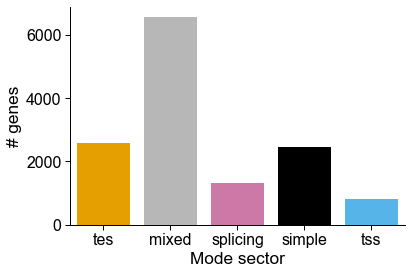

In [35]:
ax = sns.barplot(temp12, 
                 y='n_genes_w_mode',
                 x='mode_sector',
                 palette=c_dict,
                 saturation=1)
ylabel = '# genes'
xlabel = 'Mode sector'
ax.set(ylabel=ylabel, xlabel=xlabel)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


In [57]:
temp12

,mode_sector,perc,perc_mode_sect_genes,n_genes_w_mode,n_genes_cons_mode
0,tes,32.767926,18.902572,2594,850
1,mixed,19.369575,47.853968,6567,1272
2,splicing,32.262997,9.531444,1308,422
3,simple,17.992656,17.860526,2451,441
4,tss,12.453300,5.851490,803,100


[(0.0, 35.0)]

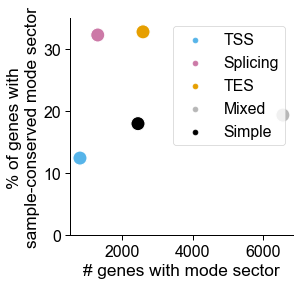

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(4,4)
ax = sns.scatterplot(temp12, 
                 x='n_genes_w_mode',
                 y='perc',
                 hue='mode_sector',
                 palette=c_dict,
                 hue_order=order,
                 s=200)
xlabel = '# genes with mode sector'
ylabel = '% of genes with\nsample-conserved mode sector'
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend().remove()
legend = ax.legend()
for text in legend.get_texts():
    t = text.get_text()
    if t in ['tss', 'tes']:
        t = t.upper()
    else:
        t = t.capitalize()
    text.set_text(t)
ax.set(ylim=(0,35))
# ax.set(ylim=(-100,7000),
#        xlim=(-100,7000))
# fname = 'figures/genes_per_mode_sector_

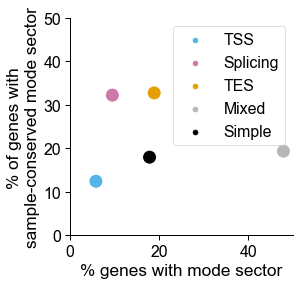

In [65]:
fig, ax = plt.subplots()
fig.set_size_inches(4,4)
ax = sns.scatterplot(temp12, 
                 x='perc_mode_sect_genes',
                 y='perc',
                 hue='mode_sector',
                 palette=c_dict,
                 hue_order=order,
                 s=200)
xlabel = '% genes with mode sector'
ylabel = '% of genes with\nsample-conserved mode sector'
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend().remove()
legend = ax.legend()
for text in legend.get_texts():
    t = text.get_text()
    if t in ['tss', 'tes']:
        t = t.upper()
    else:
        t = t.capitalize()
    text.set_text(t)
ax.set(ylim=(0,50),
       xlim=(0,50))
# ax.set(ylim=(-100,7000),
#        xlim=(-100,7000))
fname = 'figures/perc_genes_per_mode_sector_cons_scatter.pdf'
plt.savefig(fname, dpi=500)

In [66]:
temp.loc[temp.gname=='ZNF410']

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso,n_tot_genes
8178,ENSG00000119725,False,splicing,8,51,15.686275,mixed,ZNF410,protein_coding,21.0,13723
8179,ENSG00000119725,True,splicing,43,51,84.313725,mixed,ZNF410,protein_coding,21.0,13723


<AxesSubplot:xlabel='mode_sector_mouse', ylabel='mode_sector'>

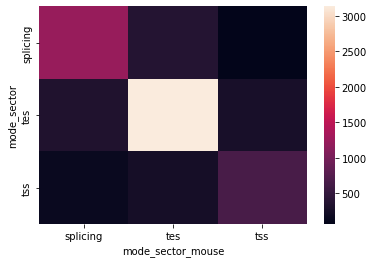

In [40]:
temp = df[['mode_sector', 'mode_sector_mouse', 'gid_human']].groupby(['mode_sector', 'mode_sector_mouse']).count().reset_index().rename({'gid_human':'n_genes'}, axis=1)
temp = temp.pivot(index='mode_sector',columns='mode_sector_mouse', values='n_genes')
sns.heatmap(temp)

## What are common mode-2nd mode pairings?

In [125]:
# temp8 = temp[['gid', 'mode_sector_edit', 'mode_sector_edit_2']].drop_duplicates()
# temp8.head()
# temp8.to_csv('sankey_for_sam_2.tsv', sep='\t', index=False)

temp8 = temp[['gid', 'mode_sector', 'mode_sector_2']].drop_duplicates()
temp8.to_csv('sankey_for_sam_3.tsv', sep='\t', index=False)

In [126]:
temp2 = temp[['gid', 'mode_sector', 'mode_sector_2']].drop_duplicates().groupby(['mode_sector', 'mode_sector_2']).count().reset_index().rename({'gid':'n_genes'}, axis=1)
temp2.sort_values(by='n_genes', ascending=False).head(10)

,mode_sector,mode_sector_2,n_genes
0,mixed,simple,2885
4,simple,mixed,1680
12,tes,mixed,1600
1,mixed,splicing,1423
2,mixed,tes,1417
8,splicing,mixed,1163
13,tes,simple,852
3,mixed,tss,772
16,tss,mixed,504
6,simple,tes,443


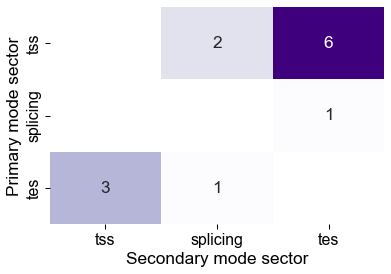

In [127]:
# make a heatmap of these
off_list = ['mixed', 'simple']
temp9 = temp2.loc[~(temp2.mode_sector.isin(off_list))&\
          ~(temp2.mode_sector_2.isin(off_list))]
temp9
temp9 = temp9.pivot(index='mode_sector_2', columns='mode_sector', values='n_genes')
c_dict, order = get_sector_colors(cats=temp9.columns.tolist())
temp9 = temp9[order]
m = dict([(s, i) for i,s in enumerate(order)])
temp9.reset_index(inplace=True)
temp9['thing'] = temp9.mode_sector_2.map(m)
temp9 = temp9.sort_values(by='thing', ascending=True)
temp9.drop('thing', axis=1, inplace=True)
temp9.set_index('mode_sector_2', inplace=True)
ax = sns.heatmap(temp9, cmap='Purples', annot=True, cbar=False)
ax.set(xlabel='Secondary mode sector', 
       ylabel='Primary mode sector')
fname = f'figures/primary_secondary_mode_corner_heatmap.pdf'
plt.savefig(fname, dpi=500)

In [128]:
# if we consider tss / tes / splicing as "corner"
d = {'mixed':'mixed',
     'splicing': 'corner',
     'tes':'corner',
     'tss':'corner',
     'simple':'simple'}
temp['mode_sector_edit'] = temp.mode_sector.map(d)
temp['mode_sector_edit_2'] = temp.mode_sector_2.map(d)
temp5 = temp.loc[temp.same_as_mode==True]
temp5 = temp5[['gid', 'mode_sector_edit', 'mode_sector_edit_2']].groupby(['mode_sector_edit', 'mode_sector_edit_2']).count().reset_index().rename({'gid':'n_genes'}, axis=1)
temp5.to_csv('primary_secondary_mode_counts.tsv', sep='\t', index=False)

In [129]:
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso,mode_sector_edit,mode_sector_edit_2
0,ENSG00000000003,False,tes,4,42,9.523810,mixed,TSPAN6,protein_coding,19.0,corner,mixed
1,ENSG00000000003,True,tes,38,42,90.476190,mixed,TSPAN6,protein_coding,19.0,corner,mixed
2,ENSG00000000419,False,mixed,24,51,47.058824,splicing,DPM1,protein_coding,10.0,mixed,corner
3,ENSG00000000419,True,mixed,27,51,52.941176,splicing,DPM1,protein_coding,10.0,mixed,corner
4,ENSG00000000457,False,mixed,27,49,55.102041,simple,SCYL3,protein_coding,5.0,mixed,simple


In [130]:
temp5
temp5['total'] = temp5.n_genes.sum()
temp5['perc'] = (temp5.n_genes/temp5.total)*100
temp5

,mode_sector_edit,mode_sector_edit_2,n_genes,total,perc
0,corner,corner,13,13457,0.096604
1,corner,mixed,3267,13457,24.277328
2,corner,simple,1250,13457,9.288846
3,mixed,corner,3612,13457,26.841049
4,mixed,simple,2885,13457,21.438656
5,simple,corner,750,13457,5.573308
6,simple,mixed,1680,13457,12.484209


In [131]:
temp.loc[(temp.mode_sector=='tes')&\
         (temp.mode_sector_2=='tss')]

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso,mode_sector_edit,mode_sector_edit_2
3620,ENSG00000100036,False,tes,30,43,69.767442,tss,SLC35E4,protein_coding,7.0,corner,corner
3621,ENSG00000100036,True,tes,13,43,30.232558,tss,SLC35E4,protein_coding,7.0,corner,corner
7662,ENSG00000116903,False,tes,26,46,56.521739,tss,EXOC8,protein_coding,7.0,corner,corner
7663,ENSG00000116903,True,tes,20,46,43.478261,tss,EXOC8,protein_coding,7.0,corner,corner
10304,ENSG00000131016,False,tes,17,37,45.945946,tss,AKAP12,protein_coding,16.0,corner,corner
10305,ENSG00000131016,True,tes,20,37,54.054054,tss,AKAP12,protein_coding,16.0,corner,corner
10639,ENSG00000132467,False,tes,30,51,58.823529,tss,UTP3,protein_coding,11.0,corner,corner
10640,ENSG00000132467,True,tes,21,51,41.176471,tss,UTP3,protein_coding,11.0,corner,corner
23133,ENSG00000185619,False,tes,27,51,52.941176,tss,PCGF3,protein_coding,18.0,corner,corner
23134,ENSG00000185619,True,tes,24,51,47.058824,tss,PCGF3,protein_coding,18.0,corner,corner


## Find a nice lookin gene w/ corner to corner double modes

In [134]:
temp.loc[(temp.mode_sector_edit=='corner')&\
         (temp.mode_sector_edit_2=='corner')&\
         (temp.same_as_mode==True)]

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso,mode_sector_edit,mode_sector_edit_2
47,ENSG00000002822,True,splicing,34,51,66.666667,tss,MAD1L1,protein_coding,22.0,corner,corner
3621,ENSG00000100036,True,tes,13,43,30.232558,tss,SLC35E4,protein_coding,7.0,corner,corner
4908,ENSG00000104689,True,tss,15,43,34.883721,tes,TNFRSF10A,protein_coding,9.0,corner,corner
6221,ENSG00000110315,True,tss,24,51,47.058824,tes,RNF141,protein_coding,12.0,corner,corner
7663,ENSG00000116903,True,tes,20,46,43.478261,tss,EXOC8,protein_coding,7.0,corner,corner
10305,ENSG00000131016,True,tes,20,37,54.054054,tss,AKAP12,protein_coding,16.0,corner,corner
10640,ENSG00000132467,True,tes,21,51,41.176471,tss,UTP3,protein_coding,11.0,corner,corner
12922,ENSG00000140988,True,splicing,38,50,76.000000,tss,RPS2,protein_coding,30.0,corner,corner
18111,ENSG00000165490,True,tes,16,45,35.555556,splicing,DDIAS,protein_coding,19.0,corner,corner
19209,ENSG00000168542,True,splicing,11,25,44.000000,tes,COL3A1,protein_coding,75.0,corner,corner


In [68]:
temp.loc[temp.gname=='DDIAS']

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso,n_tot_genes
18110,ENSG00000165490,False,tes,29,45,64.444444,splicing,DDIAS,protein_coding,19.0,13723
18111,ENSG00000165490,True,tes,16,45,35.555556,splicing,DDIAS,protein_coding,19.0,13723


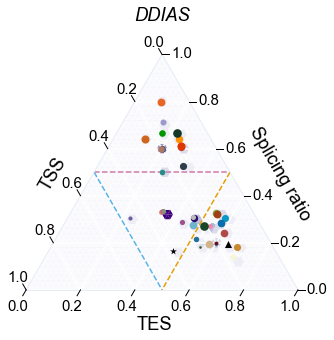

In [144]:
gene = 'DDIAS'
plot_sample_det_density_simplex(ca, gene)

In [147]:
ca.triplets.loc[(ca.triplets.sector=='splicing')&\
                (ca.triplets.gname=='DDIAS')&\
                (ca.triplets.source=='sample_det')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm
86701,sample_det,ENSG00000165490,1.0,1.0,4.0,4.0,4.000000,0.166667,0.166667,0.666667,splicing,DDIAS,calu3,19.724817
99373,sample_det,ENSG00000165490,1.0,2.0,8.0,9.0,5.333333,0.120000,0.240000,0.640000,splicing,DDIAS,caco2,41.263695
112028,sample_det,ENSG00000165490,1.0,1.0,3.0,3.0,3.000000,0.200000,0.200000,0.600000,splicing,DDIAS,huvec,16.509075
157224,sample_det,ENSG00000165490,2.0,1.0,8.0,8.0,5.333333,0.240000,0.120000,0.640000,splicing,DDIAS,wtc11,63.816219
198594,sample_det,ENSG00000165490,1.0,1.0,5.0,5.0,5.000000,0.142857,0.142857,0.714286,splicing,DDIAS,hmec,12.675893
236303,sample_det,ENSG00000165490,1.0,2.0,7.0,7.0,4.666667,0.130435,0.260870,0.608696,splicing,DDIAS,h1_de,30.925314
324764,sample_det,ENSG00000165490,1.0,1.0,8.0,8.0,8.000000,0.100000,0.100000,0.800000,splicing,DDIAS,h1,56.176109
419429,sample_det,ENSG00000165490,1.0,1.0,3.0,3.0,3.000000,0.200000,0.200000,0.600000,splicing,DDIAS,h9_chondro,6.168102
464917,sample_det,ENSG00000165490,1.0,2.0,5.0,7.0,3.333333,0.157895,0.315789,0.526316,splicing,DDIAS,mcf7,31.109856
476224,sample_det,ENSG00000165490,1.0,1.0,3.0,3.0,3.000000,0.200000,0.200000,0.600000,splicing,DDIAS,mcf10a,14.839676


In [148]:
ca.triplets.loc[(ca.triplets.sector=='tes')&\
                (ca.triplets.gname=='DDIAS')&\
                (ca.triplets.source=='sample_det')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm
21877,sample_det,ENSG00000165490,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,tes,DDIAS,colon,2.183044
62412,sample_det,ENSG00000165490,1.0,4.0,6.0,10.0,2.400000,0.135135,0.540541,0.324324,tes,DDIAS,hct116,44.704273
74339,sample_det,ENSG00000165490,1.0,3.0,2.0,3.0,1.000000,0.200000,0.600000,0.200000,tes,DDIAS,hl60_m2_24hr,3.241897
142543,sample_det,ENSG00000165490,1.0,5.0,8.0,14.0,2.666667,0.115385,0.576923,0.307692,tes,DDIAS,gm12878,27.755739
169007,sample_det,ENSG00000165490,1.0,3.0,3.0,6.0,1.500000,0.181818,0.545455,0.272727,tes,DDIAS,hl60_m2_12hr,6.957298
211137,sample_det,ENSG00000165490,1.0,3.0,2.0,4.0,1.000000,0.200000,0.600000,0.200000,tes,DDIAS,hepg2,3.715477
223459,sample_det,ENSG00000165490,1.0,5.0,4.0,8.0,1.333333,0.136364,0.681818,0.181818,tes,DDIAS,h9_panc_beta,29.094093
310928,sample_det,ENSG00000165490,1.0,3.0,3.0,6.0,1.500000,0.181818,0.545455,0.272727,tes,DDIAS,hl60_m1_24hr,5.787108
338358,sample_det,ENSG00000165490,1.0,4.0,4.0,10.0,1.600000,0.151515,0.606061,0.242424,tes,DDIAS,h9_de,45.216141
349682,sample_det,ENSG00000165490,1.0,4.0,6.0,12.0,2.400000,0.135135,0.540541,0.324324,tes,DDIAS,h9,56.493530


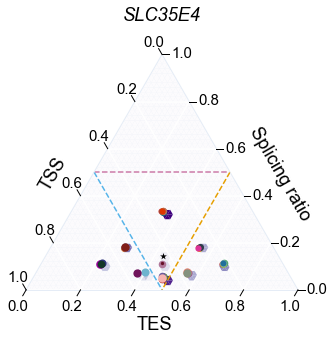

In [143]:
gene = 'SLC35E4'
plot_sample_det_density_simplex(ca, gene)

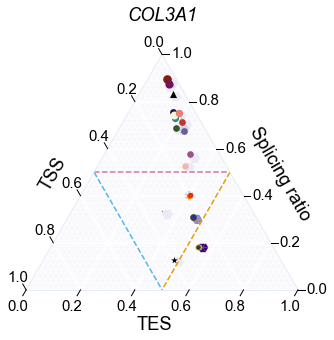

In [135]:
gene = 'COL3A1'
plot_sample_det_density_simplex(ca, gene)

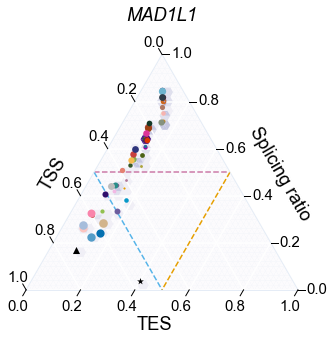

In [136]:
gene = 'MAD1L1'
plot_sample_det_density_simplex(ca, gene)

In [142]:
b = [s for s in ca.triplets.loc[ca.triplets['sample'].notnull(),
                                'sample'].unique() if 'hl60' in s]
b

['hl60_m1_12hr',
 'hl60_m2_24hr',
 'hl60_m2_12hr',
 'hl60_m1_24hr',
 'hl60_m0',
 'hl60_m1_72hr',
 'hl60',
 'hl60_m2_72hr']

## Find a nice lookin gene w/ sample conserved behavior

In [133]:
temp10 = temp.loc[(temp.same_as_mode==True)&\
         (temp.perc>=80)&\
         (temp.max_n_iso > 10)&\
         (temp.mode_sector!='mixed')&\
         (temp.mode_sector!='simple')]
temp10.to_csv('temp_sample_cons_genes.tsv', sep='\t')

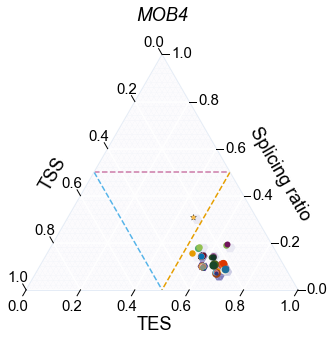

In [94]:
gene = 'MOB4'
plot_sample_det_density_simplex(ca, gene)

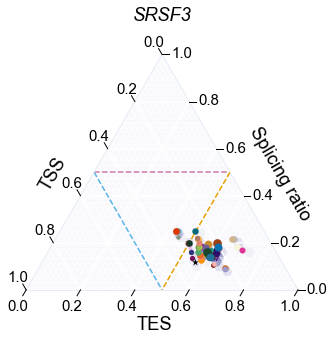

In [95]:
gene = 'SRSF3'
plot_sample_det_density_simplex(ca, gene)

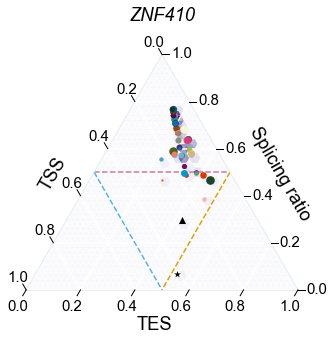

In [96]:
gene = 'ZNF410'
plot_sample_det_density_simplex(ca, gene)

## Plot a few examples

In [91]:
# first save
temp.to_csv('sample_sector_mode_cons.tsv', sep='\t', index=False)

In [92]:
temp = pd.read_csv('sample_sector_mode_cons.tsv', sep='\t')

In [53]:
ca = cerberus.read(cerberus_h5)

In [55]:
temp = temp.loc[(temp.same_as_mode==True)&(temp.perc>=80)]

In [57]:
temp.to_csv('temp_sample_sector_mode_cons.tsv', sep='\t')

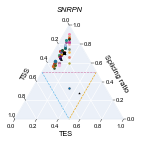

In [19]:
gene = 'SNRPN'
plot_obs_human_simplex_with_centroid(cerberus_h5,
                  gene,
                  'figures/', 
                  source='sample_det',
                  gene_subset=gene_subset,
                  ver=ver)

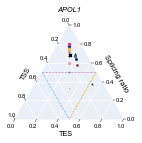

In [20]:
gene = 'APOL1'
plot_obs_human_simplex_with_centroid(cerberus_h5,
                  gene,
                  'figures/', 
                  source='sample_det',
                  gene_subset=gene_subset,
                  ver=ver)

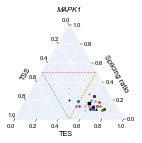

In [21]:
gene = 'MAPK1'
plot_obs_human_simplex_with_centroid(cerberus_h5,
                  gene,
                  'figures/', 
                  source='sample_det',
                  gene_subset=gene_subset,
                  ver=ver)

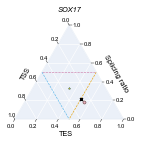

In [23]:
gene = 'SOX17'
plot_obs_human_simplex_with_centroid(cerberus_h5,
                  gene,
                  'figures/', 
                  source='sample_det',
                  gene_subset=gene_subset,
                  ver=ver)

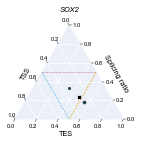

In [25]:
gene = 'SOX2'
plot_obs_human_simplex_with_centroid(cerberus_h5,
                  gene,
                  'figures/', 
                  source='sample_det',
                  gene_subset=gene_subset,
                  ver=ver)

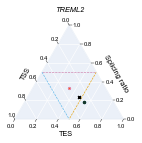

In [26]:
gene = 'TREML2'
plot_obs_human_simplex_with_centroid(cerberus_h5,
                  gene,
                  'figures/', 
                  source='sample_det',
                  gene_subset=gene_subset,
                  ver=ver)

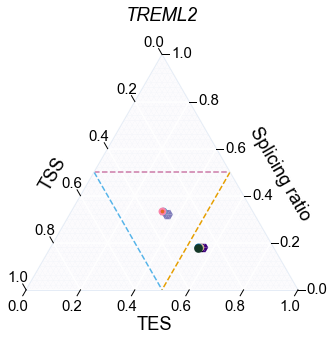

In [7]:
gene = 'TREML2'
plot_sample_det_density_simplex(ca, gene)

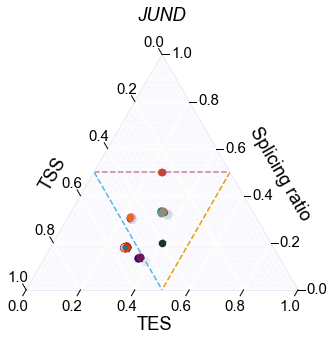

In [8]:
gene = 'JUND'
plot_sample_det_density_simplex(ca, gene)

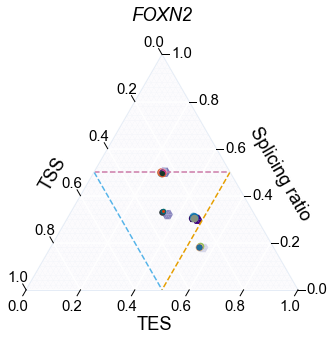

In [9]:
gene = 'FOXN2'
plot_sample_det_density_simplex(ca, gene)

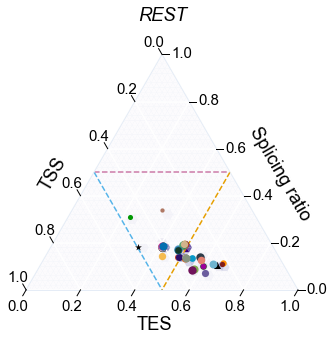

In [10]:
gene = 'REST'
plot_sample_det_density_simplex(ca, gene)

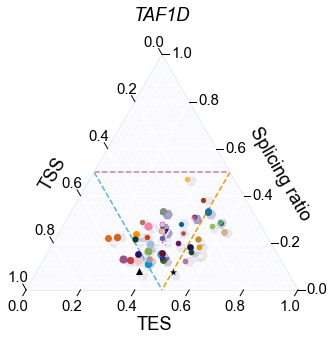

In [11]:
gene = 'TAF1D'
plot_sample_det_density_simplex(ca, gene)

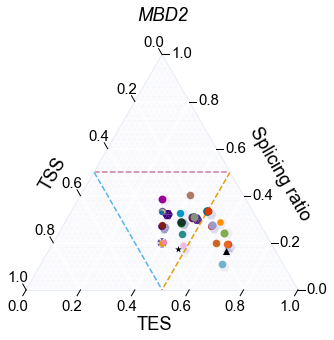

In [12]:
gene = 'MBD2'
plot_sample_det_density_simplex(ca, gene)

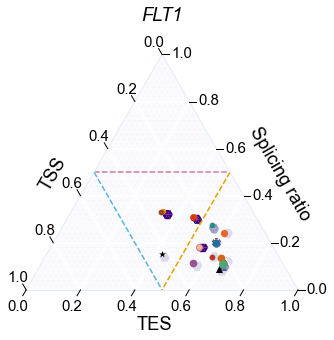

In [13]:
gene = 'FLT1'
plot_sample_det_density_simplex(ca, gene)

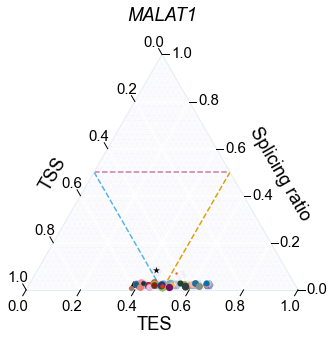

In [31]:
gene = 'MALAT1'
plot_sample_det_density_simplex(ca, gene)

In [42]:
# ca.triplets.loc[(ca.triplets.gname=='MALAT1')&\
#                 (ca.triplets.source=='sample_det')]

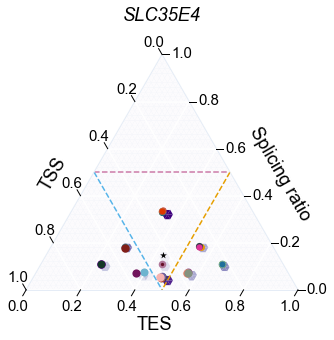

In [43]:
gene = 'SLC35E4'
plot_sample_det_density_simplex(ca, gene)

In [45]:
ca.triplets.loc[(ca.triplets.gname==gene)&\
                (ca.triplets.source=='sample_det')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm
1443,sample_det,ENSG00000100036,2.0,3.0,1.0,4.0,0.400000,0.370370,0.555556,0.074074,tes,SLC35E4,hffc6,22.104858
14644,sample_det,ENSG00000100036,3.0,3.0,1.0,6.0,0.333333,0.473684,0.473684,0.052632,mixed,SLC35E4,colon,37.666340
30265,sample_det,ENSG00000100036,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,SLC35E4,hl60_m1_12hr,4.117906
41101,sample_det,ENSG00000100036,3.0,3.0,1.0,5.0,0.333333,0.473684,0.473684,0.052632,mixed,SLC35E4,ovary,10.836935
56390,sample_det,ENSG00000100036,3.0,3.0,1.0,5.0,0.333333,0.473684,0.473684,0.052632,mixed,SLC35E4,hct116,18.746954
80929,sample_det,ENSG00000100036,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,SLC35E4,calu3,10.762908
93152,sample_det,ENSG00000100036,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,SLC35E4,caco2,3.404667
106235,sample_det,ENSG00000100036,3.0,1.0,1.0,3.0,0.500000,0.666667,0.222222,0.111111,tss,SLC35E4,huvec,35.462524
118619,sample_det,ENSG00000100036,3.0,3.0,1.0,7.0,0.333333,0.473684,0.473684,0.052632,mixed,SLC35E4,heart,16.557146
136468,sample_det,ENSG00000100036,3.0,3.0,1.0,6.0,0.333333,0.473684,0.473684,0.052632,mixed,SLC35E4,gm12878,11.769158


## Are species-conserved genes more likely to be sample conserved?

In [5]:
df = pd.read_csv(human_mouse_sect_cons, sep='\t')
print(len(df.index))
df['sector_conserved'] = df.sector_human == df.sector_mouse
df['splicing_conserved']  = (df.sector_human=='splicing')&(df.sector_mouse=='splicing')
gids = df.loc[(df.sector_human=='splicing')&(df.sector_mouse!='splicing')]['Gene stable ID'].tolist()


temp = pd.read_csv('sample_sector_mode_cons.tsv', sep='\t')
temp = temp.loc[(temp.same_as_mode==True)]
temp['sample_sect_conserved'] = temp.perc>=min_perc
temp.head()

13494


,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname_x,gname_y,biotype_category,sample_sect_conserved
1,ENSG00000000003,True,tes,38,42,90.476190,mixed,TSPAN6,TSPAN6,protein_coding,True
3,ENSG00000000419,True,mixed,27,51,52.941176,splicing,DPM1,DPM1,protein_coding,False
5,ENSG00000000457,True,mixed,22,49,44.897959,simple,SCYL3,SCYL3,protein_coding,False
7,ENSG00000000460,True,mixed,27,46,58.695652,simple,C1orf112,C1orf112,protein_coding,False
9,ENSG00000000938,True,mixed,13,23,56.521739,simple,FGR,FGR,protein_coding,False


In [6]:
df.head()

,Gene stable ID,Mouse gene stable ID,source_human,gid_human,n_tss_human,n_tes_human,n_ic_human,n_iso_human,splicing_ratio_human,tss_ratio_human,...,spl_ratio_mouse,sector_mouse,gname_mouse,sample_mouse,gene_tpm_mouse,biotype_category_mouse,dist,z_score,sector_conserved,splicing_conserved
0,ENSG00000065135,ENSMUSG00000000001,obs_mm_major,ENSG00000065135,1.0,3.0,1.0,3.0,0.500000,0.222222,...,0.333333,simple,Gnai3,NaN,NaN,protein_coding,0.250956,1.083932,False,False
1,ENSG00000093009,ENSMUSG00000000028,obs_mm_major,ENSG00000093009,1.0,1.0,6.0,6.0,6.000000,0.125000,...,0.324324,mixed,Cdc45,NaN,NaN,protein_coding,0.309879,1.728264,False,False
2,ENSG00000102098,ENSMUSG00000000037,obs_mm_major,ENSG00000102098,1.0,1.0,2.0,2.0,2.000000,0.250000,...,0.390244,mixed,Scml2,NaN,NaN,protein_coding,0.094295,-0.629199,True,False
3,ENSG00000141562,ENSMUSG00000000056,obs_mm_major,ENSG00000141562,2.0,2.0,8.0,10.0,4.000000,0.250000,...,0.307692,mixed,Narf,NaN,NaN,protein_coding,0.166471,0.160065,True,False
4,ENSG00000105971,ENSMUSG00000000058,obs_mm_major,ENSG00000105971,3.0,4.0,3.0,6.0,0.857143,0.381818,...,0.333333,simple,Cav2,NaN,NaN,protein_coding,0.199584,0.522163,False,False


In [7]:
df = df[['Gene stable ID', 'sector_conserved', 'sector_human', 'sector_mouse', 'dist']]
df.rename({'Gene stable ID': 'gid'}, axis=1, inplace=True)
temp = temp.merge(df, how='inner', on='gid')
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname_x,gname_y,biotype_category,sample_sect_conserved,sector_conserved,sector_human,sector_mouse,dist
0,ENSG00000000003,True,tes,38,42,90.476190,mixed,TSPAN6,TSPAN6,protein_coding,True,True,tes,tes,0.097033
1,ENSG00000000457,True,mixed,22,49,44.897959,simple,SCYL3,SCYL3,protein_coding,False,True,mixed,mixed,0.062068
2,ENSG00000000460,True,mixed,27,46,58.695652,simple,C1orf112,C1orf112,protein_coding,False,True,tes,tes,0.095669
3,ENSG00000000938,True,mixed,13,23,56.521739,simple,FGR,FGR,protein_coding,False,False,mixed,simple,0.135247
4,ENSG00000001036,True,mixed,44,50,88.000000,tes,FUCA2,FUCA2,protein_coding,True,False,mixed,tes,0.091388


In [8]:
temp['sample_species_cons'] = temp['sector_conserved'].astype(str)+'_'+\
                              temp['sample_sect_conserved'].astype(str)

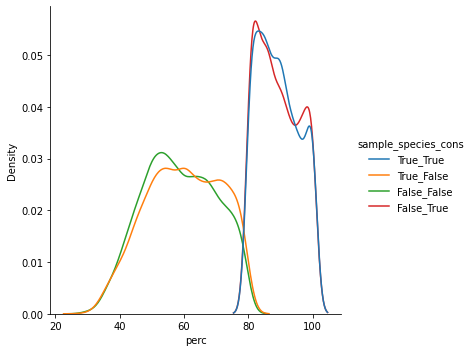

In [9]:
sns.displot(temp, x='perc',
            hue='sample_species_cons',
            kind='kde',
            common_norm=False)

In [10]:
temp.head()
# sns.displot(temp, x='perc',
#             hue='sample_species_cons',
#             kind='kde',
#             common_norm=False)

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname_x,gname_y,biotype_category,sample_sect_conserved,sector_conserved,sector_human,sector_mouse,dist,sample_species_cons
0,ENSG00000000003,True,tes,38,42,90.476190,mixed,TSPAN6,TSPAN6,protein_coding,True,True,tes,tes,0.097033,True_True
1,ENSG00000000457,True,mixed,22,49,44.897959,simple,SCYL3,SCYL3,protein_coding,False,True,mixed,mixed,0.062068,True_False
2,ENSG00000000460,True,mixed,27,46,58.695652,simple,C1orf112,C1orf112,protein_coding,False,True,tes,tes,0.095669,True_False
3,ENSG00000000938,True,mixed,13,23,56.521739,simple,FGR,FGR,protein_coding,False,False,mixed,simple,0.135247,False_False
4,ENSG00000001036,True,mixed,44,50,88.000000,tes,FUCA2,FUCA2,protein_coding,True,False,mixed,tes,0.091388,False_True


In [11]:
temp2 = temp[['gid', 'sample_species_cons']].groupby('sample_species_cons').count().reset_index().rename({'gid': 'n_genes'}, axis=1)
temp2.head()

,sample_species_cons,n_genes
0,False_False,4377
1,False_True,1217
2,True_False,3190
3,True_True,1147


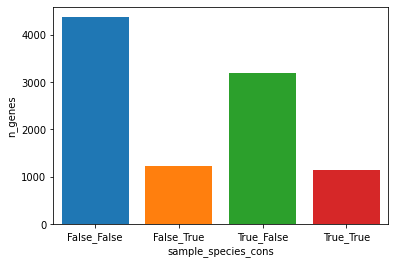

In [12]:
ax = sns.barplot(temp2, x='sample_species_cons', y='n_genes', saturation=1)

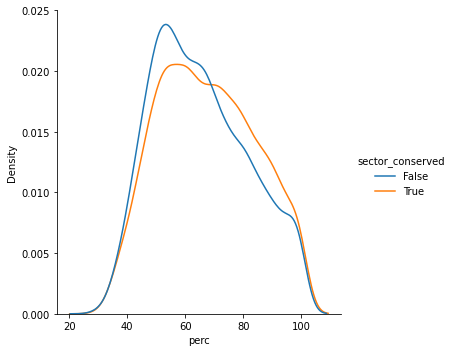

In [13]:
# temp2 = temp.loc[temp.same_as_mode==True].copy(deep=True)
sns.displot(temp, x='perc',
            hue='sector_conserved',
            kind='kde',
            common_norm=False)

<AxesSubplot:xlabel='perc', ylabel='dist'>

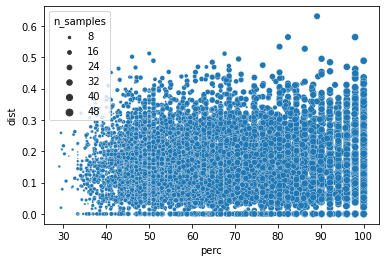

In [14]:
# plot distance (species cons) to the perc values (sample cons)
temp.head()
sns.scatterplot(temp, x='perc', y='dist', size='n_samples', sizes=(2,50))

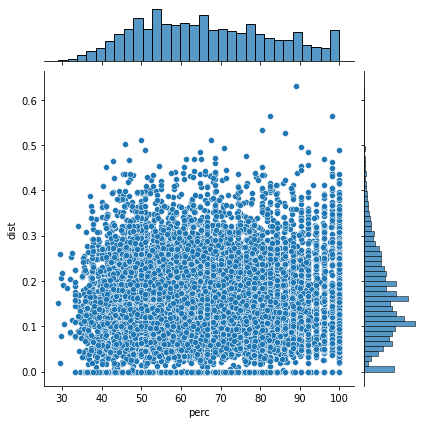

In [15]:
sns.jointplot(temp, x='perc', y='dist')


In [18]:
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname_x,gname_y,biotype_category,sample_sect_conserved,sector_conserved,sector_human,sector_mouse,dist,sample_species_cons
0,ENSG00000000003,True,tes,38,42,90.476190,mixed,TSPAN6,TSPAN6,protein_coding,True,True,tes,tes,0.097033,True_True
1,ENSG00000000457,True,mixed,22,49,44.897959,simple,SCYL3,SCYL3,protein_coding,False,True,mixed,mixed,0.062068,True_False
2,ENSG00000000460,True,mixed,27,46,58.695652,simple,C1orf112,C1orf112,protein_coding,False,True,tes,tes,0.095669,True_False
3,ENSG00000000938,True,mixed,13,23,56.521739,simple,FGR,FGR,protein_coding,False,False,mixed,simple,0.135247,False_False
4,ENSG00000001036,True,mixed,44,50,88.000000,tes,FUCA2,FUCA2,protein_coding,True,False,mixed,tes,0.091388,False_True


In [20]:
x = temp.dist.tolist()
y = temp.perc.tolist()

r, pval = stats.pearsonr(x,y)
print(f'Corr. between percentage sample mode conserved samples and distance between human and mouse points, pearson r={r} and pval={pval}')

print()

rho, pval = stats.spearmanr(x,y)
print(f'Corr. between percentage sample mode conserved samples and distance between human and mouse points, spearman rho={rho} and pval={pval}')


Corr. between percentage sample mode conserved samples and distance between human and mouse points, pearson r=0.021318459699812532 and pval=0.033632335448124696

Corr. between percentage sample mode conserved samples and distance between human and mouse points, spearman rho=0.004143838905002446 and pval=0.679678720978312


## Compare the mouse mode to the human mode

In [24]:
# get the orths
df = pd.read_csv(human_mouse_sect_cons, sep='\t')
df.head()
df = df[['Gene stable ID', 'Mouse gene stable ID']].rename({'Gene stable ID': 'gid_human',
                                                            'Mouse gene stable ID': 'gid_mouse'}, 
                                                           axis=1)
# df.head()

In [25]:
temp = pd.read_csv('sample_sector_mode_cons.tsv', sep='\t')
temp.rename({'gid':'gid_human'}, axis=1, inplace=True)
temp2 = pd.read_csv('mouse_sample_sector_mode_cons.tsv', sep='\t')
temp2.rename({'gid':'gid_mouse'}, axis=1, inplace=True)

In [26]:
df = df.merge(temp,
              how='inner',
              on='gid_human',
              suffixes=('', '_human'))
df = df.merge(temp2,
              how='inner',
              on='gid_mouse',
              suffixes=('', '_mouse'))

In [34]:
# remove mixed because I care only about the points
df = df.loc[(df.mode_sector!='mixed')&(df.mode_sector_mouse!='mixed')]

In [35]:
df['mode_sector_conserved'] = df['mode_sector'] == df['mode_sector_mouse']

In [36]:
df.head()

,gid_human,gid_mouse,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname_x,gname_y,...,same_as_mode_mouse,mode_sector_mouse,n_samples_mouse,n_tot_samples_mouse,perc_mouse,mode_sector_2_mouse,gname,biotype_category_mouse,max_n_iso,mode_sector_conserved
22,ENSG00000121068,ENSMUSG00000000093,False,tes,2,20,10.000000,simple,TBX2,TBX2,...,False,tes,8,28,28.571429,mixed,Tbx2,protein_coding,8.0,True
23,ENSG00000121068,ENSMUSG00000000093,False,tes,2,20,10.000000,simple,TBX2,TBX2,...,True,tes,20,28,71.428571,mixed,Tbx2,protein_coding,8.0,True
24,ENSG00000121068,ENSMUSG00000000093,True,tes,18,20,90.000000,simple,TBX2,TBX2,...,False,tes,8,28,28.571429,mixed,Tbx2,protein_coding,8.0,True
25,ENSG00000121068,ENSMUSG00000000093,True,tes,18,20,90.000000,simple,TBX2,TBX2,...,True,tes,20,28,71.428571,mixed,Tbx2,protein_coding,8.0,True
42,ENSG00000106009,ENSMUSG00000000148,False,splicing,22,51,43.137255,mixed,BRAT1,BRAT1,...,False,splicing,5,32,15.625000,mixed,Brat1,protein_coding,5.0,True


<AxesSubplot:xlabel='mode_sector_mouse', ylabel='mode_sector'>

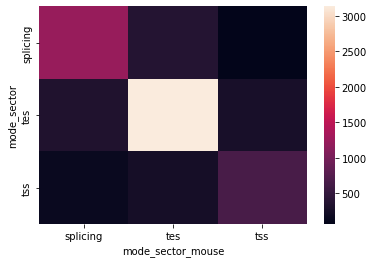

In [40]:
temp = df[['mode_sector', 'mode_sector_mouse', 'gid_human']].groupby(['mode_sector', 'mode_sector_mouse']).count().reset_index().rename({'gid_human':'n_genes'}, axis=1)
temp = temp.pivot(index='mode_sector',columns='mode_sector_mouse', values='n_genes')
sns.heatmap(temp)